## Lets's try downloading data for one particular year. Years 1990-1995 and 2008-2019 don't have all the columns in NOAA csv files so they will return empty array

In [12]:
import pandas as pd
import requests
from io import BytesIO

base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
year = 2019
creation = "20250520"

details_file = f"StormEvents_details-ftp_v1.0_d{year}_c{creation}.csv.gz"
locations_file = f"StormEvents_locations-ftp_v1.0_d{year}_c{creation}.csv.gz"

#function for downloading files
def download_csv_gz(file_name):
    url = base_url + file_name
    print(f"Downloading {url}")
    r = requests.get(url)
    r.raise_for_status()
    return pd.read_csv(BytesIO(r.content), compression='gzip', low_memory=False)


df_details = download_csv_gz(details_file)
df_locations = download_csv_gz(locations_file)

df_details.columns = df_details.columns.str.lower()
df_locations.columns = df_locations.columns.str.lower()

assert 'event_id' in df_details.columns, "event_id missing from details"
assert 'event_id' in df_locations.columns, "event_id missing from locations"

# Merge the two datasets on 'event_id'
df_merged = pd.merge(df_details, df_locations, on='event_id', suffixes=('_details', '_loc'), how='inner')

# Filter for tornadoes with valid EF scale
df_tornadoes = df_merged[
    (df_merged['event_type'] == 'Tornado') &
    (df_merged['tor_f_scale'].isin(['F0', 'F1', 'F2', 'F3', 'F4', 'F5']))
]


tornado_summary = df_tornadoes.groupby(['state','begin_lat', 'begin_lon','tor_f_scale']).size().reset_index(name='count')


tornado_summary.to_csv("tornado_2005_summary.csv", index=False)


In [11]:
print(tornado_summary.head())

Empty DataFrame
Columns: [state, begin_lat, begin_lon, tor_f_scale, count]
Index: []


In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point


df = pd.read_csv("tornado_2005_summary.csv") 


df['severity'] = df['tor_f_scale'].map({
    'F0': 'Low', 'F1': 'Low', 'F2': 'Low',
    'EF0': 'Low', 'EF1': 'Low', 'EF2': 'Low',
    'F3': 'High', 'F4': 'High', 'F5': 'High',
    'EF3': 'High', 'EF4': 'High', 'EF5': 'High'
})


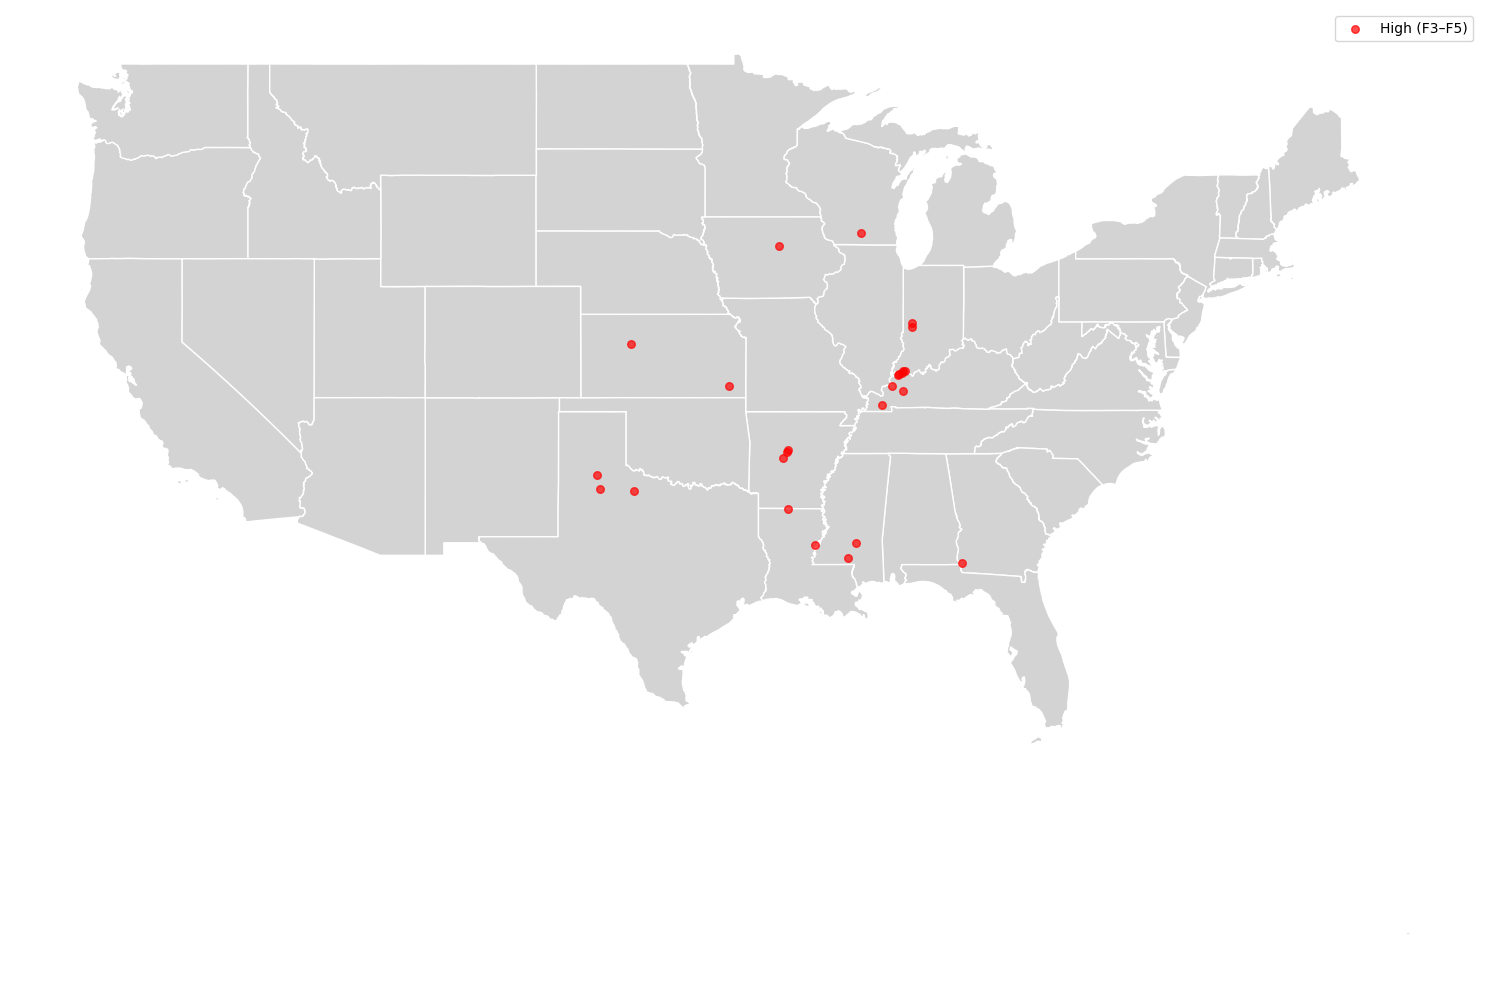

In [11]:

geometry = [Point(xy) for xy in zip(df['begin_lon'], df['begin_lat'])]


gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


us_states_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip"


states = gpd.read_file(us_states_url)



excluded_states = [
    'ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
    'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS'
]


states['NAME'] = states['NAME'].str.upper()


contiguous_states = states[~states['NAME'].isin(excluded_states)]


gdf['state'] = gdf['state'].str.upper()
gdf_contiguous = gdf[~gdf['state'].isin(excluded_states)]

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15, 10))

contiguous_states.plot(ax=ax, color='lightgray', edgecolor='white')


#gdf_contiguous[gdf_contiguous['severity'] == 'Low'].plot(
#    ax=ax, color='green', markersize=20, alpha=0.6, label='Low (F0–F2)')


gdf_contiguous[gdf_contiguous['severity'] == 'High'].plot(
    ax=ax, color='red', markersize=30, alpha=0.7, label='High (F3–F5)')


ax.set_axis_off()
ax.legend()
plt.tight_layout()
plt.show()


## Running for loop to download it for years ranging from 1990-2019. Then we will bin them in the size of 2-3 years.

In [ ]:
import pandas as pd
import requests
from io import BytesIO
from shapely.geometry import Point
import geopandas as gpd

base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
creation_date = "20250520"  
all_years_data = []


for year in range(1990, 2020):
    print(f"\nProcessing year: {year}")

    details_file = f"StormEvents_details-ftp_v1.0_d{year}_c{creation_date}.csv.gz"


    locations_file = f"StormEvents_locations-ftp_v1.0_d{year}_c{creation_date}.csv.gz"

    def download_csv_gz(file_name):
        url = base_url + file_name
        try:
            r = requests.get(url)
            r.raise_for_status()
            return pd.read_csv(BytesIO(r.content), compression='gzip', low_memory=False)
        except Exception as e:
            print(f"Failed to load {file_name}: {e}")
            return None

    df_details = download_csv_gz(details_file)
    df_locations = download_csv_gz(locations_file)

    if df_details is None or df_locations is None:
        continue

    df_details.columns = df_details.columns.str.lower()
    df_locations.columns = df_locations.columns.str.lower()

    if 'event_id' not in df_details.columns or 'event_id' not in df_locations.columns:
        continue

    
    df_merged = pd.merge(df_details, df_locations, on='event_id', suffixes=('_details', '_loc'), how='inner')

    
    df_tornadoes = df_merged[
    (df_merged['event_type'] == 'Tornado') &
    (df_merged['tor_f_scale'].isin(['F0', 'F1', 'F2', 'F3', 'F4', 'F5']))].copy()

    df_tornadoes['year'] = year  


    if df_tornadoes.empty:
        continue

    
    df_tornadoes['year'] = year
    all_years_data.append(df_tornadoes[['state', 'begin_lat', 'begin_lon', 'tor_f_scale', 'year']])


combined_df = pd.concat(all_years_data, ignore_index=True)

def year_to_bin(y):
    base = y - (y % 3)
    return f"{base}-{base + 2}"

combined_df['year_bin'] = combined_df['year'].apply(year_to_bin)

# Group by bin + location + EF scale
binned_summary = combined_df.groupby(['year_bin', 'state', 'begin_lat', 'begin_lon', 'tor_f_scale']) \
                            .size().reset_index(name='count')

# Save to CSV
binned_summary.to_csv("tornado_1990_2020_binned_summary.csv", index=False)
print("\nDone! Saved: tornado_1990_2020_binned_summary.csv")



## Checking for which years we were actually able to get the data

In [2]:
combined_df = pd.concat(all_years_data, ignore_index=True)
print("Years collected:", sorted(combined_df['year'].unique()))


Years collected: [1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]


## Plotting the data from the csv file. Using geopandas for the overall plot. Removing some states from the analysis

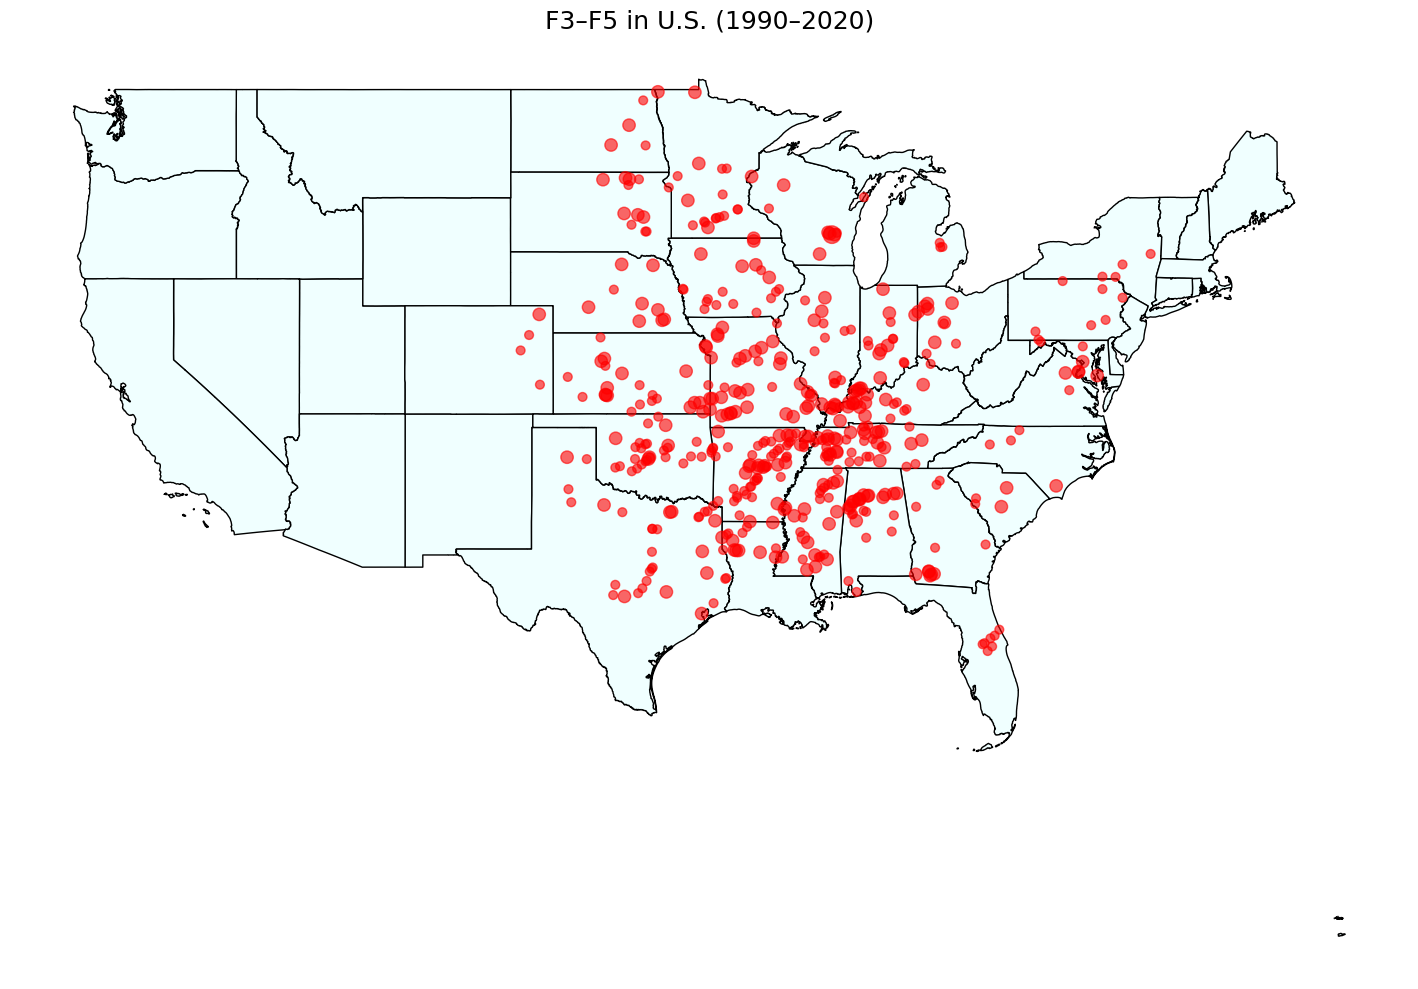

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


df = pd.read_csv("tornado_1990_2020_binned_summary.csv")


high_df = df[df['tor_f_scale'].isin(['F3', 'F4', 'F5'])]


geometry = [Point(xy) for xy in zip(high_df['begin_lon'], high_df['begin_lat'])]
gdf = gpd.GeoDataFrame(high_df, geometry=geometry, crs="EPSG:4326")


us_states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip")

excluded_states = [
    'ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
    'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS'
]

us_states['NAME'] = us_states['NAME'].str.upper()
contiguous_states = us_states[~us_states['NAME'].isin(excluded_states)]


fig, ax = plt.subplots(figsize=(15, 10))


contiguous_states.plot(ax=ax, color='azure', edgecolor='black')


gdf.plot(ax=ax, color='red', markersize=gdf['count'] * 40, alpha=0.6)


ax.set_title("F3–F5 in U.S. (1990–2020)", fontsize=18)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [5]:
df['year_bin'].unique()

array(['1995-1997', '1998-2000', '2001-2003', '2004-2006', '2007-2009'],
      dtype=object)

## Now plotting this for all the differentbins separately. Note- size of the markers have been scaled according to the number of tornado counts

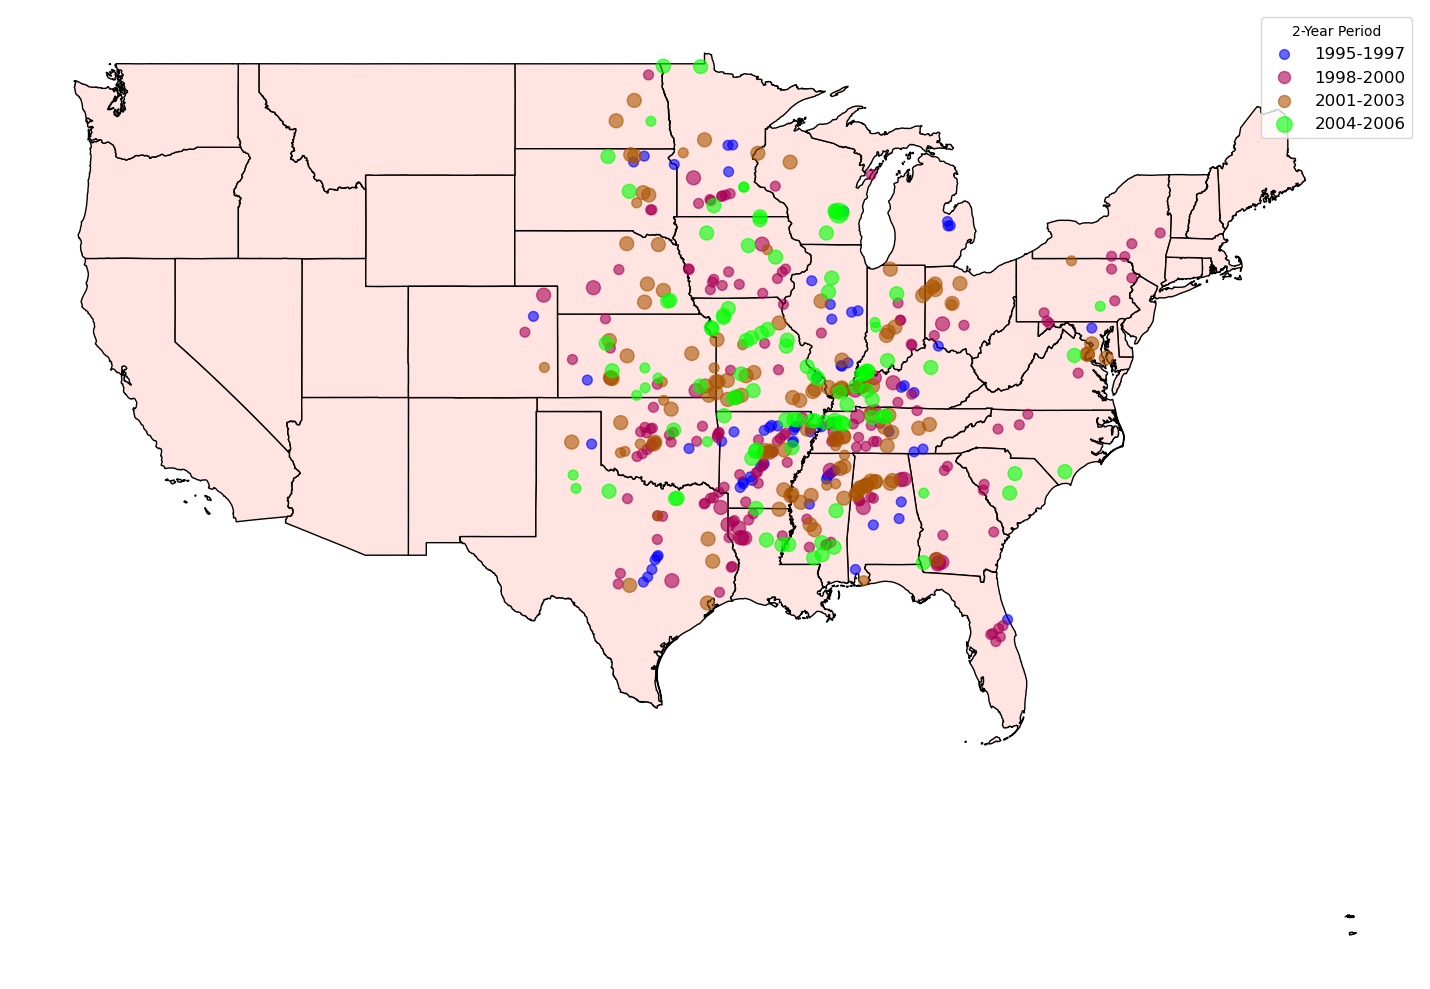

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


bins = sorted(gdf['year_bin'].unique())


fig, ax = plt.subplots(figsize=(15, 10))


contiguous_states.plot(ax=ax, color='mistyrose', edgecolor='black')


colors = cm.get_cmap('brg', len(bins))  


for i, bin_label in enumerate(bins):
    bin_data = gdf[
        (gdf['year_bin'] == bin_label) & 
        (gdf['tor_f_scale'].isin(['F3', 'F4', 'F5']))
    ]
    if not bin_data.empty:
        bin_data.plot(
            ax=ax,
            color=colors(i),
            markersize=bin_data['count']*50,
            alpha=0.6,
            label=bin_label
        )


ax.set_axis_off()
ax.legend(title='2-Year Period', loc='best', fontsize=12)
plt.tight_layout()
plt.show()



## Making contour plots using gaussian_kde for each individual bins

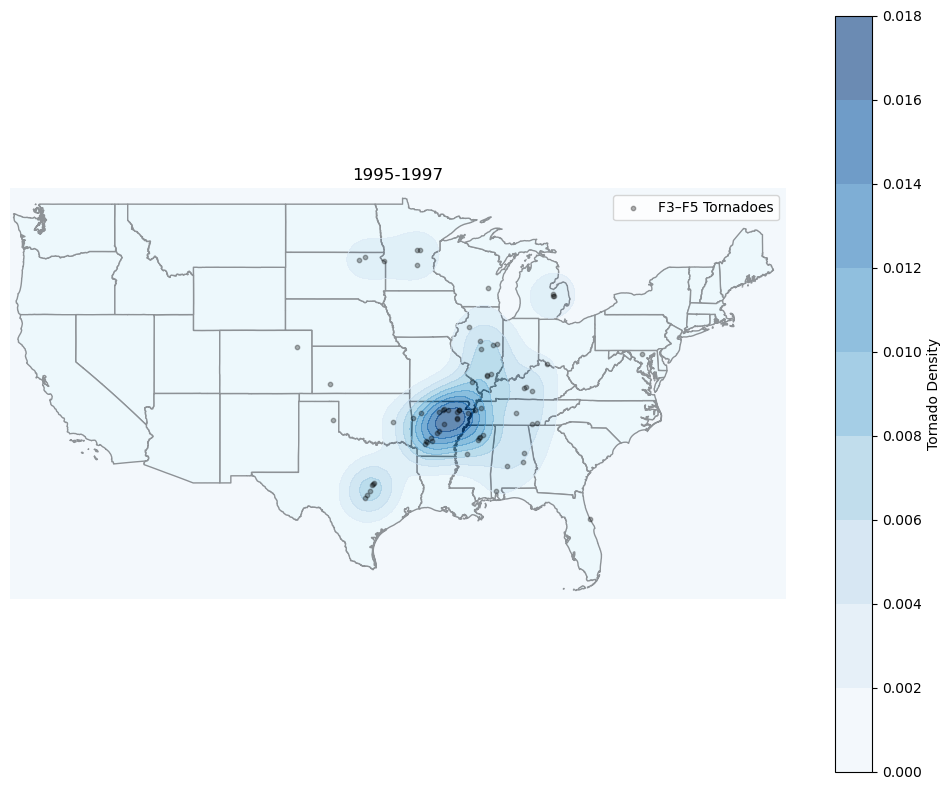

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


fig, ax = plt.subplots(figsize=(10, 8))


contiguous_states.plot(ax=ax, color='azure', edgecolor='black')


bin_label = '1995-1997' 


bin_data = gdf[
    (gdf['year_bin'] == bin_label) &
    (gdf['tor_f_scale'].isin(['F3', 'F4', 'F5']))
]


x = bin_data['begin_lon'].values
y = bin_data['begin_lat'].values


if len(x) > 0:
    # Perform kernel density estimation
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=0.3)  # bandwidth can be tuned

    
    xmin, xmax = -125, -66
    ymin, ymax = 24, 50

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    density = kde(positions).reshape(xx.shape)

    
    contour = ax.contourf(xx, yy, density, levels=10, cmap='Blues', alpha=0.6)
    plt.colorbar(contour, ax=ax, label='Tornado Density')

   
    ax.scatter(x, y, c='black', s=10, alpha=0.3, label='F3–F5 Tornadoes')

    ax.set_title('1995-1997')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_axis_off()
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"No data found for bin: {bin_label}")


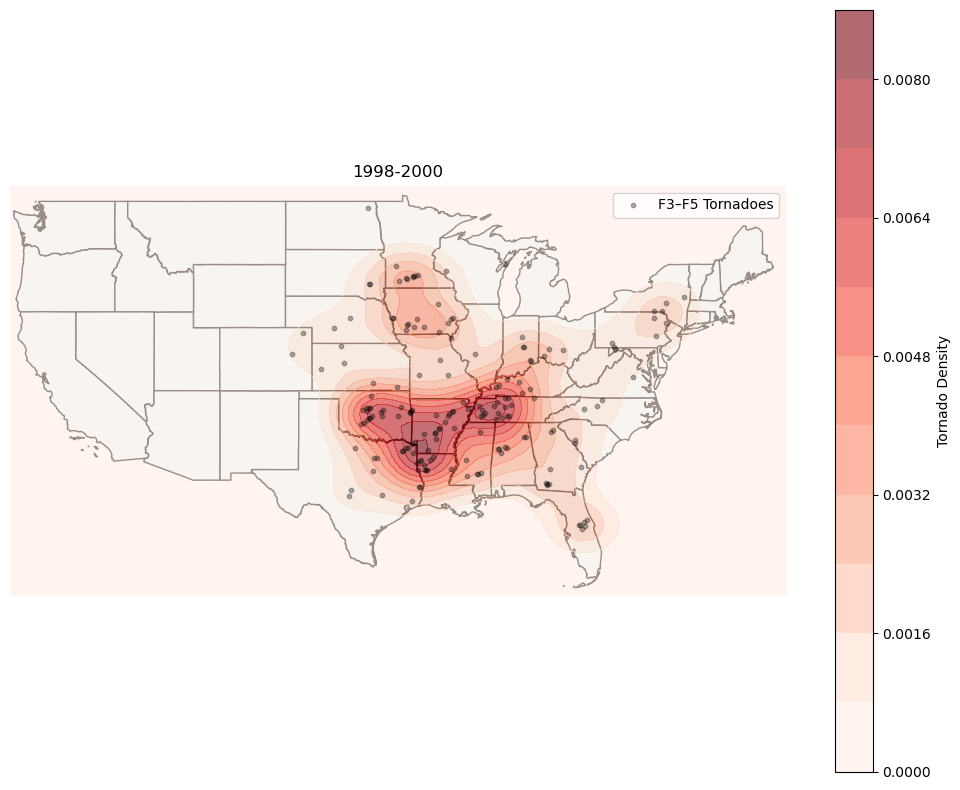

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


fig, ax = plt.subplots(figsize=(10, 8))


contiguous_states.plot(ax=ax, color='azure', edgecolor='black')


bin_label = '1998-2000' 


bin_data = gdf[
    (gdf['year_bin'] == bin_label) &
    (gdf['tor_f_scale'].isin(['F3', 'F4', 'F5']))
]


x = bin_data['begin_lon'].values
y = bin_data['begin_lat'].values


if len(x) > 0:
    # Perform kernel density estimation
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=0.3)  # bandwidth can be tuned

    
    xmin, xmax = -125, -66
    ymin, ymax = 24, 50

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    density = kde(positions).reshape(xx.shape)

    
    contour = ax.contourf(xx, yy, density, levels=10, cmap='Reds', alpha=0.6)
    plt.colorbar(contour, ax=ax, label='Tornado Density')

   
    ax.scatter(x, y, c='black', s=10, alpha=0.3, label='F3–F5 Tornadoes')

    ax.set_title('1998-2000')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_axis_off()
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"No data found for bin: {bin_label}")


In [16]:
max_idx = np.argmax(density)
peak_lon = positions[0][max_idx]
peak_lat = positions[1][max_idx]
print(f"Highest tornado density for {bin_label} near: lat={peak_lat:.2f}, lon={peak_lon:.2f}")


Highest tornado density for 1998-2000 near: lat=33.45, lon=-94.01


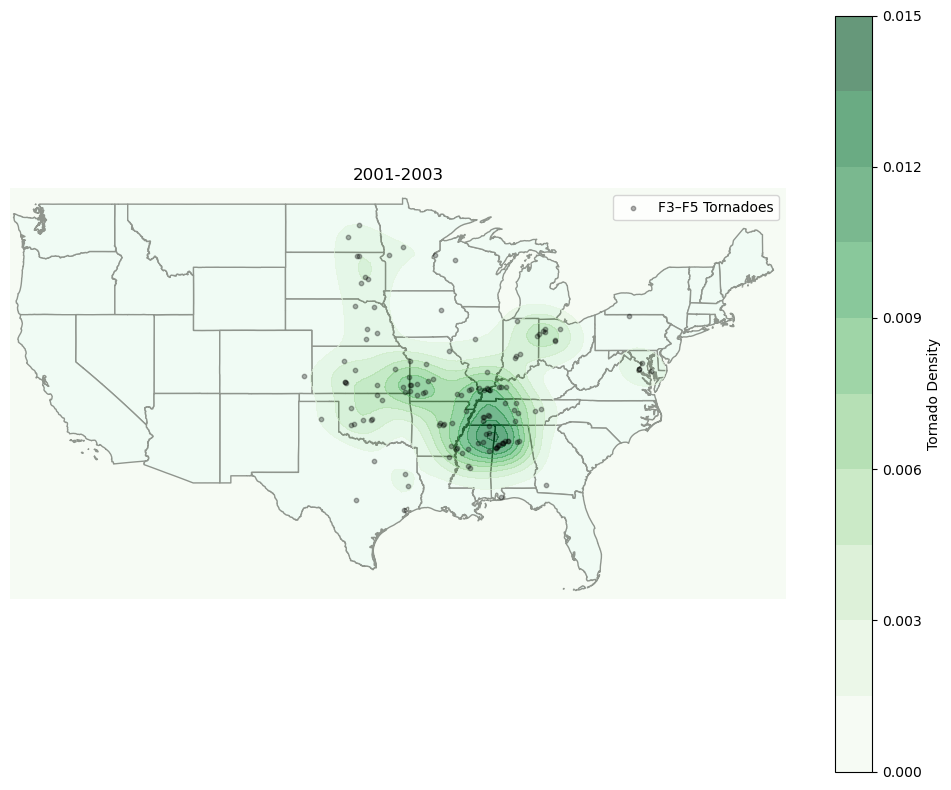

Highest tornado density for 2001-2003 near: lat=34.24, lon=-88.05


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


fig, ax = plt.subplots(figsize=(10, 8))


contiguous_states.plot(ax=ax, color='azure', edgecolor='black')


bin_label = '2001-2003' 


bin_data = gdf[
    (gdf['year_bin'] == bin_label) &
    (gdf['tor_f_scale'].isin(['F3', 'F4', 'F5']))
]


x = bin_data['begin_lon'].values
y = bin_data['begin_lat'].values


if len(x) > 0:
    # Perform kernel density estimation
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=0.3)  # bandwidth can be tuned

    
    xmin, xmax = -125, -66
    ymin, ymax = 24, 50

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    density = kde(positions).reshape(xx.shape)

    
    contour = ax.contourf(xx, yy, density, levels=10, cmap='Greens', alpha=0.6)
    plt.colorbar(contour, ax=ax, label='Tornado Density')

   
    ax.scatter(x, y, c='black', s=10, alpha=0.3, label='F3–F5 Tornadoes')

    ax.set_title('2001-2003')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_axis_off()
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"No data found for bin: {bin_label}")
max_idx = np.argmax(density)
peak_lon = positions[0][max_idx]
peak_lat = positions[1][max_idx]
print(f"Highest tornado density for {bin_label} near: lat={peak_lat:.2f}, lon={peak_lon:.2f}")


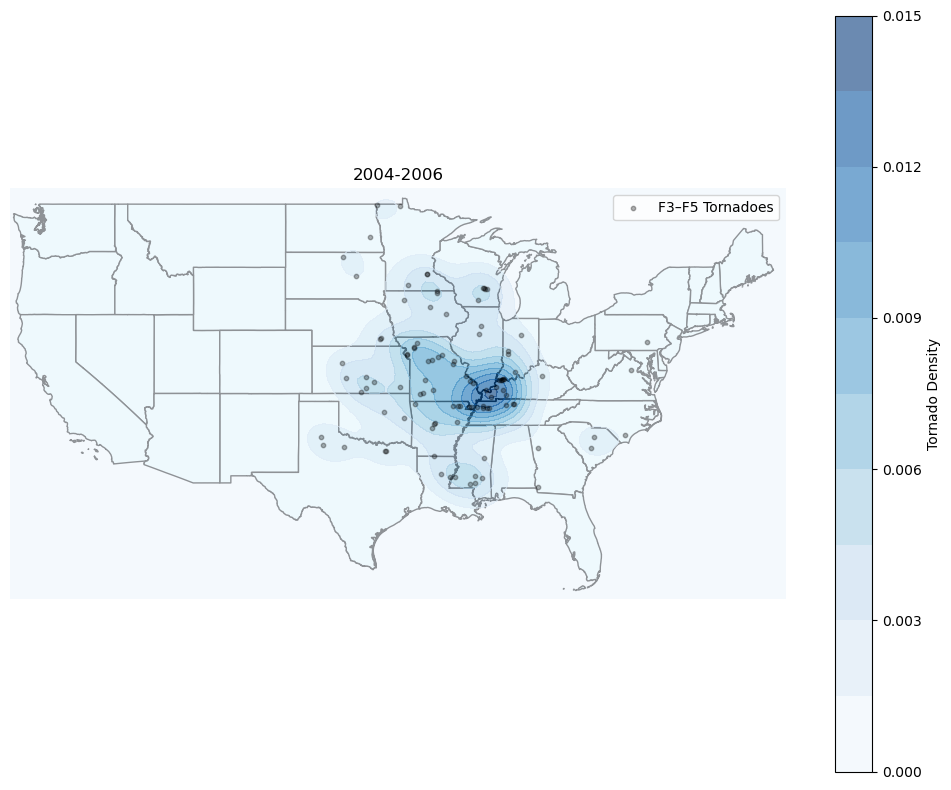

Highest tornado density for 2004-2006 near: lat=36.87, lon=-88.65


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


fig, ax = plt.subplots(figsize=(10, 8))


contiguous_states.plot(ax=ax, color='azure', edgecolor='black')


bin_label = '2004-2006' 


bin_data = gdf[
    (gdf['year_bin'] == bin_label) &
    (gdf['tor_f_scale'].isin(['F3', 'F4', 'F5']))
]


x = bin_data['begin_lon'].values
y = bin_data['begin_lat'].values


if len(x) > 0:
    # Perform kernel density estimation
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=0.3)  # bandwidth can be tuned

    
    xmin, xmax = -125, -66
    ymin, ymax = 24, 50

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    density = kde(positions).reshape(xx.shape)

    
    contour = ax.contourf(xx, yy, density, levels=10, cmap='Blues', alpha=0.6)
    plt.colorbar(contour, ax=ax, label='Tornado Density')

   
    ax.scatter(x, y, c='black', s=10, alpha=0.3, label='F3–F5 Tornadoes')

    ax.set_title('2004-2006')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_axis_off()
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"No data found for bin: {bin_label}")
max_idx = np.argmax(density)
peak_lon = positions[0][max_idx]
peak_lat = positions[1][max_idx]
print(f"Highest tornado density for {bin_label} near: lat={peak_lat:.2f}, lon={peak_lon:.2f}")
